In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import *
from starData import *



#==============================================================================
#  SET UP
#==============================================================================

solar = 1.988544*10**30 # in kg
year = 3.154*10**7 #year in seconds
jup = 1898.13*10**24 #in kg
earth = 5.97219e24 #in kg
AU = 1.496*10**11 #in m

dayToYear = 365.25; 

#Convert gravitational constant to astronomical units (AU) and solar masses

G_old = 6.67259e-11 # in m^3/(kg-s^2)
newG = G_old*(1/AU)**3/(1/solar*(1/(year))**2)
G = newG # Gravitational Constant

N = 4000; #Iterations
dt = .01; #Time step (years)
checkMaximallyPacked = 0; # CHANGE TO 1 TO ADD A PLANET BETWEEN MARS AND JUPITER AND MAINTAIN STABLE ORBITS

if (checkMaximallyPacked ==1):
    planets =11; #Includes Pluto, remembering the good ol' days. It also includes the Sun.
    x,y, z,vx ,vy ,vz = np.zeros((planets,N+1)),np.zeros((planets,N+1)),np.zeros((planets,N+1)),\
        np.zeros((planets,N+1)),np.zeros((planets,N+1)),np.zeros((planets,N+1));
    vxPacked = vxPacked*dayToYear;
    vyPacked = vyPacked*dayToYear;
    vzPacked = vzPacked*dayToYear 
    m = mPacked;
    for i in range(planets):
        #These arrays come the starData.py


        x[i][0] = xPacked[i][0];
        y[i][0] = yPacked[i][0];
        z[i][0] = zPacked[i][0];

        vx[i][0] = vxPacked[i][0];
        vy[i][0] = vyPacked[i][0];
        vz[i][0] = vzPacked[i][0];
else:
    planets =10; #Includes Pluto, remembering the good ol' days. It also includes the Sun. 
    x,y, z,vx ,vy ,vz = np.zeros((planets,N+1)),np.zeros((planets,N+1)),np.zeros((planets,N+1)),\
    np.zeros((planets,N+1)),np.zeros((planets,N+1)),np.zeros((planets,N+1));
    vxSet = vxSet*dayToYear;
    vySet = vySet*dayToYear;
    vzSet = vzSet*dayToYear
    for i in range(planets):
        #These arrays come the starData.py

        x[i][0] = xSet[i][0];
        y[i][0] = ySet[i][0];
        z[i][0] = zSet[i][0];
        vx[i][0] = vxSet[i][0];
        vy[i][0] = vySet[i][0];
        vz[i][0] = vzSet[i][0];  


timeSpace = np.arange(0,dt*N,dt)
timePeriod = np.arange(0,dt*10,dt)
ChangeInEnergy = np.zeros(N); # Record change in energy to check validity of code
h = np.zeros((N,planets,3)) # variable for momentum
ChangeInH = np.zeros(N); # change in momentum
totalH = np.zeros((N,3)) # total momentum
hChange = np.zeros(N) #placeholder for momentum to check code

energy = np.zeros(N); 

mag = np.zeros((planets,planets)) # distances between planets
#acceleration
axNew,ayNew,azNew = np.zeros((planets,planets)),np.zeros((planets,planets)),np.zeros((planets,planets))
ax = np.zeros((planets,N))
ay = np.zeros((planets,N))
az = np.zeros((planets,N))
axPull, ayPull,azPull = np.zeros((planets,1)),np.zeros((planets,1)),np.zeros((planets,1))

#position and velocity at Cartesian vector components

vBary= np.zeros((N,3)) # Velocity barycenter
rBary = np.zeros((N,3)) #barycenter position

  



#==============================================================================
#  function definitions
#==============================================================================
    
def magnitude(x,y,z):
    # x,y,z : coordinates of planet
    return sqrt(x**2 + y**2 +z**2)
    
def momentum(m,x,y,z,vx,vy,vz):
    r = [x,y,z];
    vel = [vx,vy,vz];
    H = m*np.cross(r,vel,axis=0);
    return H;

# Update position of planet with Leap frog method, 
# 2*dt is the length of the time step for leap frog
def position(xOld,yOld,zOld,vx,vy,vz,dt): 
    xNew = xOld+2*dt*vx
    yNew = yOld+2*dt*vy
    zNew = zOld+2*dt*vz
    return xNew,yNew,zNew

def positionEuler(x,y,z,vx,vy,vz,dt): # Get position using the Euler method
    xNew = x + vx*dt;
    yNew = y + vy*dt;
    zNew = z + vz*dt;
    return xNew,yNew,zNew;
    
def acceleration(x,y,z,xPull,yPull,zPull, mag, G,mPull): # Get acceleration of celestial body
    ax = G * mPull * (xPull-x)/mag**3;
    ay = G * mPull * (yPull-y)/mag**3;
    az = G * mPull * (zPull-z)/mag**3;
    return ax,ay,az
    
def velocity(vxOld,vyOld,vzOld,ax,ay,az,dt): # Get velocity of planet with leap frog method
    vxNew = vxOld + 2*dt*ax
    vyNew = vyOld + 2*dt*ay
    vzNew = vzOld + 2*dt*az

    return vxNew,vyNew,vzNew;
    
def velocityEuler(vx,vy,vz,ax,ay,az,dt): #Euler method
    vxNew = vx + ax*dt;
    vyNew = vy + ay*dt;
    vzNew = vz + az*dt;
    
    return vxNew,vyNew,vzNew;
    
def makeAccelArray(ax,ay,az):
    ax = np.array([ax])
    ay = np.array([ay])
    az = np.array([az])
    return ax,ay,az;
    
def appendArray(aa,bb,cc,a,b,c):
    d = np.append(aa,a);
    e = np.append(bb,b);
    f = np.append(cc,c);
    return d,e,f;
    
def kinetic(m,vx,vy,vz): # Kinetic Energy
    KE = 1/2 *m* (vx**2+vy**2+vz**2);
    return KE;
    
def potential(G,m,mPull,mag): # Gravitational Potential
    #     G : Gravitational constant
    #     m : mass of planet
    # mPull : mass of other object (probably the Sun)
    #   mag : magnitude displacement
    #
    U = -G*m*mPull/mag;
    return U;
    
def barycenter(m,mTot,x,y,z): # Find Barycenter
    #    m : mass of planet
    # mTot : total mass of system
    # x,y,z: position coordinates of planet
    #
    baryX = (m*x)/mTot
    baryY = (m*y)/mTot
    baryZ = (m*z)/mTot
    return baryX,baryY,baryZ;

def nOrbit(x,y,z,xPull,yPull,zPull,vx,vy,vz,vxPull,vyPull,vzPull,G,m,mPull,n,planets,dt): # this is the bulk of the code
    #                  x,y,z : inital position coordinates of astronomical body
    #    xPull, yPull, zPull : initial position coordinates of other astronomical body interacting with astro body #1
    #               vx,vy,vz : initial velocity components of astro body #1
    # vxPull, vyPull, vzPull : initial velocity components of astro body #1
    #                      G : Gravitational constant
    #                      m : mass of planet
    #                  mPull : mass of other object (probably the Sun)
    #                      n : Number of iterations
    #                     dt : Time step (years)
    mTot = 0;
    rAdd = 0;
    vAdd = 0;
    for j in range(planets):
         mTot += m[j] # total mass of solar system
                                                      
    for i in range(n):   
        
        
#==============================================================================
#acceleration
#==============================================================================
    
#Get distance between all included celestial bodies
        for j in range(planets):
            for k in range(j,planets,1):
                mag[j][k] = magnitude(x[j][i]-xPull[k][i],y[j][i]-yPull[k][i],z[j][i]-zPull[k][i]);
            if j > 0:
                for p in range(j):
                    mag[j][p] = mag[p][j]; #symmetry, distance between one planet is the same as the distance from the other

# Find acceleration due to gravity
        for j in range(planets):
            for k in range(planets):
                if j != k:
                     axNew[j][k],ayNew[j][k],azNew[j][k] = acceleration(x[j][i],y[j][i],z[j][i],\
                     xPull[k][i], yPull[k][i],zPull[k][i],mag[j][k],G,mPull[k]);
            sumAxNew,sumAyNew,sumAzNew = np.sum(axNew[j]),np.sum(ayNew[j]),np.sum(azNew[j])                                       
            ax[j][i],ay[j][i],az[j][i] = sumAxNew,sumAyNew,sumAzNew

#==============================================================================
#   velocity  
#==============================================================================

#At the beginning of the array, you can't use leap frog, so it suffices to use the 1st order Euler method
        if i==0:
            for j in range(planets):
                vxNew,vyNew,vzNew = velocityEuler(vx[j][i],vy[j][i],vz[j][i],ax[j][i],ay[j][i],az[j][i],dt)
                vx[j][i+1],vy[j][i+1],vz[j][i+1] = vxNew,vyNew,vzNew;
        else: # Use leap frog method to update velocity
            for j in range(planets):
                vxNew,vyNew,vzNew = velocity(vx[j][i-1],vy[j][i-1],vz[j][i-1],ax[j][i],ay[j][i],az[j][i],dt);
                vx[j][i+1],vy[j][i+1],vz[j][i+1] = vxNew,vyNew,vzNew;
                 
            
#==============================================================================
# Energy        
#==============================================================================
# Because energy is conserved,
# the change in energy should be due to round off error in the simulation. 

        KEhold = 0; #Kinetic energy placeholder
        PEhold = 0; #Potential energy placeholder

        for j in range(planets):
            KEhold += kinetic(m[j],vx[j][i],vy[j][i],vz[j][i])
        for j in range(planets):
            for k in range(j,planets,1):
                if j != k:
                    PEhold += potential(G,m[j],mPull[k], mag[j][k])
                    
        energy[i] = KEhold + PEhold;

        ChangeInEnergy[i] = abs(energy[i])-abs(energy[0]);


##==============================================================================
## check barycenter which should be 0
##==============================================================================
        for j in range(planets):
            rAdd = barycenter(m[j],mTot,x[j][i],y[j][i],z[j][i],)
            rBary[i] = rBary[i] + rAdd
            vAdd = barycenter(m[j],mTot,vx[j][i],vy[j][i],vz[j][i],)
            vBary[i] = vBary[i] + vAdd        
        rAdd = 0;
        vAdd= 0;

#==============================================================================
#  new position
#==============================================================================
    
# Get position with Euler method for i==0      
        if i ==0:
            for j in range(planets):
                xNew,yNew,zNew = positionEuler (x[j][i],y[j][i],z[j][i],vx[j][i],\
                                      vy[j][i],vz[j][i],dt) ;
                x[j][i+1],y[j][i+1],z[j][i+1] = xNew,yNew,zNew;
                xPull[j][i+1],yPull[j][i+1],zPull[j][i+1] = xNew,yNew,zNew;
# Update position with leap frog method
        else:
            for j in range(planets):
                xNew,yNew,zNew = position (x[j][i-1],y[j][i-1],z[j][i-1],vx[j][i],\
                                      vy[j][i],vz[j][i],dt);
                x[j][i+1],y[j][i+1],z[j][i+1] = xNew,yNew,zNew;
                xPull[j][i+1],yPull[j][i+1],zPull[j][i+1] = xNew,yNew,zNew;

##==============================================================================
## momentum (no mass)
##==============================================================================
        for j in range(planets):
            h[i][j] = momentum(m[j],x[j][i],y[j][i],z[j][i],vx[j][i],vy[j][i],vz[j][i])
            totalH[i] = np.sum(h[i],axis = 0)
    hTotalMag = np.linalg.norm(totalH)
    hTotComb = np.linalg.norm(totalH,axis =1)
    ChangeInH = hTotComb - hTotComb[0]
    hRatio = ChangeInH / hTotalMag
    
            
# ChangeInEnergy,hMag,hPullMag,bary,vbary

    return x,y,z,vx,vy,vz,ax,ay,az,energy, ChangeInEnergy, totalH,ChangeInH,hRatio, hTotalMag,rBary,vBary;


#==============================================================================
#  RUN SCRIPT
#==============================================================================
    
a,b,c,va,vb,vc,aa,ab,ac,energy, ChangeInE,totalH, ChangeInH,hRatio,hTotalMag, rBary,vBary = nOrbit(x,y,z,x,y,z,vx,vy,vz,vx,vy,vz,G,m,m,N,planets,dt);

datestr = "June 20, 1988 - June 20, 2028"

#==============================================================================
# Plot the orbits of the planets. The sun gets a little covered up by the orbit
# of Mercury and Venus. 
#==============================================================================

plt.figure(0)
for i in range(planets):
    plt.plot(a[i],b[i],color = [(i%2)/2,(i%3)/3,(((planets-1)+i)%4)/4])
    # plt.plot(a[0],b[0],'k',a[1],b[1],'k',a[2],b[2],'k',a[3],b[3],'k',a[4],\
    #     b[4],'k',a[5],b[5],'k',a[6],b[6],'k',a[7],b[7],'k',a[8],b[8],'k',a[9],b[9],'k')
plt.title("Solar System, "+datestr,{'size':'14'});
plt.grid('on')
plt.axis('equal')
if (checkMaximallyPacked ==1):
    plt.legend(['Sun','Mercury','Venus','Earth','Mars','PlanetX','Jupiter','Saturn','Neptune','Uranus','Pluto']) 
else:
    plt.legend(['Sun','Mercury','Venus','Earth','Mars','Jupiter','Saturn','Neptune','Uranus','Pluto'])     
# I don't plot Pluto because it's so far, but it's there
plt.xlabel("x (AU)", {'size':'14'});
plt.ylabel("y (AU)", {'size':'14'});
#savefig('NBodyOrbit10.png', bbox_inches='tight'); 
plt.show()

#==============================================================================
#  Plot the change in total energy of the solar system. The energy oscillates due to machine error.
# If the time step is smaller, the change in total energy reduces. For 10 years, with a time step of .001 years for
# 10,000 iterations, the change in energy was order 10^7.
#==============================================================================

plt.figure(1)
plt.plot(timeSpace,ChangeInE,'k')
# plt.legend(['Sun','Mercury','Venus','Earth','Mars','Jupiter','Saturn','Neptune','Uranus','Pluto'])
plt.title("Change in Energy, "+datestr,{'size':'14'});
plt.xlabel("dt (Year)", {'size':'14'});
plt.ylabel("$M_J * AU^2 / (2\pi*year)^2$", {'size':'14'});
plt.show();

# savefig('NBodyOrbit10Energy.png', bbox_inches='tight'); 

#==============================================================================
#  Plot the change in momentum divided by total momentum of the solar system. Again, the error is due to machine error.
#  The machine error doesn't go away over time, but it oscillates, which I assume means the errors cancel out, most likely
#  due to the symmetry and oscillation of the orbits of the planets and that the leap frog method conserves energy. 
#  The change in momentum is not quite centered at zero, which suggests the barycenter is not exactly zero. 
#==============================================================================

plt.figure(2)
plt.plot(timeSpace, hRatio,'k')
#plt.legend(['Sun','Mercury','Venus','Earth','Mars','Jupiter','Saturn','Neptune','Uranus','Pluto'])
plt.title("Angular Momentum, \n"+datestr,{'size':'14'});
plt.xlabel("dt (Year)", {'size':'14'});
plt.ylabel("Change in Momentum / Total Momentum", {'size':'14'});
plt.show();

#savefig('NBodyOrbit100Momentum.png', bbox_inches='tight'); 

ModuleNotFoundError: No module named 'starData'

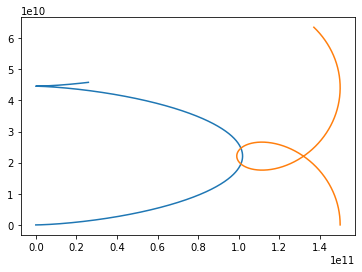

In [3]:
G = 6.67e-11
Ma = 2e30
Mb = 4e30
AU = 1.5e11
daysec = 24*60*60

gravconst = G*Ma*Mb

xa,ya,za = 0.0,0.0,0.0
xva,yva,zva = 0.0,0.0,0.0

xb,yb,zb = 1*AU,0.0,0.0
xvb,yvb,zvb = 0,10000,0

t=0.0
dt = 0.01*daysec

xalist=[]
yalist=[]
xblist=[]
yblist=[]

while t< 100*daysec:
    rx = xb-xa
    ry = yb-ya
    rz = zb-za
    modr3 = (rx**2+ry**2+rz**2)**1.5
    
    fx = -gravconst*rx/modr3
    fy = -gravconst*ry/modr3
    fz = -gravconst*rz/modr3
    
    xvb += fx*dt/Mb
    yvb += fy*dt/Mb
    zvb += fz*dt/Mb
    
    xb += xvb * dt
    yb += yvb * dt
    zb += zvb * dt
    
    xva += -fx*dt/Ma
    yva += -fy*dt/Ma
    zva += -fz*dt/Ma
    
    xa += xva * dt
    ya += yva * dt
    za += zva * dt    
    
    t += dt
    
    xalist.append(xa)
    yalist.append(ya)
    
    xblist.append(xb)
    yblist.append(yb)
    
plt.plot(xalist, yalist)
plt.plot(xblist, yblist)
    
    

In [2]:
import numpy as np
import matplotlib.pyplot as plt


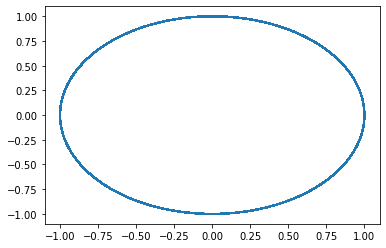

In [4]:
def accel(x, y, t):
    r2=x*x+y*y
    f0=-x/r2
    f1=-y/r2
    return [f0,f1]

x, y, vx, vy,t=1,0,0,1,0


x1=[x]
y1=[y]
vx1=[vx]
vy1=[vy]


T=[0]
tmax=3000
f=accel(x, y, t)
hdt=0.005
dt=0.01
vx=vx+hdt*f[0]
vy=vy+hdt*f[1]
t+=hdt
while(t<=tmax):
    x=x+dt*vx
    y=y+dt*vy
    t=t+hdt
    
    
    
    f=accel(x,y,t)
    vhx=vx+hdt*f[0]
    vhy=vy+hdt*f[1]
    
    
    x1.append(x)
    y1.append(y)
    vx1.append(vhx)
    vy1.append(vhy)

    vx=vx+dt*f[0]
    vy=vy+dt*f[1]
    t=t+hdt
    T.append(t)
    
plt.plot(x1, y1)

